## Process data by drive

In [1]:
import importlib
import main

Using TensorFlow backend.
D:\Apps\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
importlib.reload(main)

<module 'main' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\main.py'>

In [3]:
main.drive('../../data/', 'dump/', '2018-09-01')

Raw data shapes:
que (22726, 5) (23931, 5)
ans (45838, 5) (51123, 5)
pro (22658, 5) (28152, 5)
stu (29631, 3) (30971, 3)
tag_que (76553, 4)
tag_pro (76553, 4)
Train
Positive pairs number: 44474, negative: 44474
Questions:  (22726, 16)


Students features: 22597it [00:19, 1147.22it/s]


Students:  (34282, 15)


Professionals features: 44848it [00:08, 5253.68it/s]


Professionals:  (53512, 34)
Train data dump.

Test
Positive pairs number: 5249, negative: 49723
Questions:  (23931, 16)


Students features: 23801it [00:22, 1043.61it/s]


Students:  (36105, 15)


Professionals features: 50106it [00:09, 5129.31it/s]


Professionals:  (60173, 34)
Test data dump.



## Load processed data

In [2]:
import pickle
import pandas as pd
import evaluation

In [3]:
with open('proc_data/train_que_data.npy', 'rb') as f:
    train_que_data = pickle.load(f)
with open('proc_data/train_stu_data.npy', 'rb') as f:
    train_stu_data = pickle.load(f)
with open('proc_data/train_pro_data.npy', 'rb') as f:
    train_pro_data = pickle.load(f)
with open('proc_data/train_pos_pairs', 'rb') as f:
    train_pos_pairs = pickle.load(f)
with open('proc_data/train_nonneg_pairs', 'rb') as f:
    train_nonneg_pairs = pickle.load(f)
with open('proc_data/train_pro_dates', 'rb') as f:
    train_pro_dates = pickle.load(f)

In [4]:
with open('proc_data/test_que_data.npy', 'rb') as f:
    test_que_data = pickle.load(f)
with open('proc_data/test_stu_data.npy', 'rb') as f:
    test_stu_data = pickle.load(f)
with open('proc_data/test_pro_data.npy', 'rb') as f:
    test_pro_data = pickle.load(f)
with open('proc_data/test_pos_pairs', 'rb') as f:
    test_pos_pairs = pickle.load(f)
with open('proc_data/test_nonneg_pairs', 'rb') as f:
    test_nonneg_pairs = pickle.load(f)
with open('proc_data/test_pro_dates', 'rb') as f:
    test_pro_dates = pickle.load(f)

In [5]:
with open('dump/preprocessors.pkl', 'rb') as f:
    pp = pickle.load(f)
    que_proc = pp['questions_date_added_time']

## Create train and test batch generators

In [6]:
import generator

In [7]:
importlib.reload(generator)

<module 'generator' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\generator.py'>

In [8]:
train_bg = generator.BatchGenerator(
    train_que_data, train_stu_data, train_pro_data, 64,
    train_pos_pairs, train_nonneg_pairs, que_proc, train_pro_dates)
print('Batches:', len(train_bg))

Batches: 694


In [9]:
test_bg = generator.BatchGenerator(
    test_que_data, test_stu_data, test_pro_data, 64,
    test_pos_pairs, test_nonneg_pairs, que_proc, test_pro_dates)
print('Batches:', len(test_bg))

Batches: 82


---

## Compute que_date_idx and pro_date_idx

In [10]:
import numpy as np

In [11]:
que_cols = list(train_stu_data.columns[2:]) + list(train_que_data.columns[2:]) + ['questions_current_time']
pro_cols = list(train_pro_data.columns[2:]) + ['professionals_current_time']
print(len(que_cols), len(pro_cols))
print(train_bg[0][0][0].shape[1], train_bg[0][0][1].shape[1])

28 33
28 33


In [12]:
que_date_mask = np.zeros(len(que_cols), dtype=bool)
for i, col in enumerate(que_cols):
    if ('date' in col) or ('time' in col):
        que_date_mask[i] = True
(que_date_mask == 1).sum()

10

In [13]:
pro_date_mask = np.zeros(len(pro_cols), dtype=bool)
for i, col in enumerate(pro_cols):
    if ('date' in col) or ('time' in col):
        pro_date_mask[i] = 1
(pro_date_mask == 1).sum()

7

---

## Model training and testing

In [14]:
from keras.optimizers import Adam
import models

In [15]:
importlib.reload(models)

<module 'models' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\models.py'>

In [58]:
# in train mode, build, compile, train and save model
double_model = models.DoubleModel(
    len(que_cols), que_date_mask, [102, 42], [2, 2],
    len(pro_cols), pro_date_mask, [102, 102, 42], [2, 2, 2],
    15, 10, 5, 3,
)

In [60]:
double_model.content_model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])
double_model.content_model.fit_generator(train_bg, epochs=2)
double_model.content_model.evaluate_generator(test_bg)

Epoch 1/2
694/694 [==============================] - ETA: 13:15 - loss: 0.4089 - acc: 0.85 - ETA: 2:46 - loss: 0.4332 - acc: 0.8141 - ETA: 1:36 - loss: 0.4385 - acc: 0.814 - ETA: 1:09 - loss: 0.4430 - acc: 0.811 - ETA: 55s - loss: 0.4383 - acc: 0.809 - ETA: 46s - loss: 0.4415 - acc: 0.80 - ETA: 40s - loss: 0.4381 - acc: 0.81 - ETA: 35s - loss: 0.4367 - acc: 0.81 - ETA: 32s - loss: 0.4355 - acc: 0.81 - ETA: 29s - loss: 0.4347 - acc: 0.81 - ETA: 27s - loss: 0.4370 - acc: 0.80 - ETA: 25s - loss: 0.4365 - acc: 0.80 - ETA: 24s - loss: 0.4344 - acc: 0.80 - ETA: 23s - loss: 0.4326 - acc: 0.81 - ETA: 22s - loss: 0.4325 - acc: 0.81 - ETA: 21s - loss: 0.4333 - acc: 0.81 - ETA: 20s - loss: 0.4352 - acc: 0.81 - ETA: 20s - loss: 0.4350 - acc: 0.81 - ETA: 19s - loss: 0.4364 - acc: 0.80 - ETA: 18s - loss: 0.4370 - acc: 0.80 - ETA: 18s - loss: 0.4376 - acc: 0.80 - ETA: 17s - loss: 0.4374 - acc: 0.80 - ETA: 17s - loss: 0.4363 - acc: 0.81 - ETA: 16s - loss: 0.4362 - acc: 0.81 - ETA: 16s - loss: 0.4384 -

694/694 [==============================] - ETA: 1:37 - loss: 0.4067 - acc: 0.812 - ETA: 1:25 - loss: 0.4011 - acc: 0.828 - ETA: 41s - loss: 0.4080 - acc: 0.815 - ETA: 27s - loss: 0.4102 - acc: 0.82 - ETA: 22s - loss: 0.4168 - acc: 0.82 - ETA: 20s - loss: 0.4263 - acc: 0.81 - ETA: 18s - loss: 0.4222 - acc: 0.81 - ETA: 17s - loss: 0.4185 - acc: 0.82 - ETA: 17s - loss: 0.4158 - acc: 0.82 - ETA: 16s - loss: 0.4172 - acc: 0.82 - ETA: 15s - loss: 0.4143 - acc: 0.82 - ETA: 15s - loss: 0.4156 - acc: 0.82 - ETA: 14s - loss: 0.4163 - acc: 0.82 - ETA: 14s - loss: 0.4153 - acc: 0.82 - ETA: 14s - loss: 0.4141 - acc: 0.82 - ETA: 14s - loss: 0.4125 - acc: 0.82 - ETA: 13s - loss: 0.4122 - acc: 0.82 - ETA: 13s - loss: 0.4097 - acc: 0.83 - ETA: 13s - loss: 0.4102 - acc: 0.83 - ETA: 12s - loss: 0.4089 - acc: 0.83 - ETA: 12s - loss: 0.4107 - acc: 0.83 - ETA: 12s - loss: 0.4105 - acc: 0.83 - ETA: 11s - loss: 0.4104 - acc: 0.83 - ETA: 11s - loss: 0.4107 - acc: 0.83 - ETA: 11s - loss: 0.4119 - acc: 0.82 - ET

[0.3678515960530537, 0.8566120426829268]

In [52]:
double_model.date_model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])
double_model.date_model.fit_generator(train_bg, epochs=1)
double_model.date_model.evaluate_generator(test_bg)

Epoch 1/1
694/694 [==============================] - ETA: 10:06 - loss: 0.2839 - acc: 0.87 - ETA: 2:08 - loss: 0.3087 - acc: 0.8672 - ETA: 1:15 - loss: 0.3068 - acc: 0.867 - ETA: 55s - loss: 0.3104 - acc: 0.863 - ETA: 44s - loss: 0.3147 - acc: 0.86 - ETA: 37s - loss: 0.3091 - acc: 0.86 - ETA: 34s - loss: 0.3074 - acc: 0.86 - ETA: 30s - loss: 0.3091 - acc: 0.86 - ETA: 27s - loss: 0.3075 - acc: 0.86 - ETA: 25s - loss: 0.3057 - acc: 0.87 - ETA: 23s - loss: 0.3050 - acc: 0.86 - ETA: 22s - loss: 0.3067 - acc: 0.86 - ETA: 21s - loss: 0.3077 - acc: 0.86 - ETA: 20s - loss: 0.3095 - acc: 0.86 - ETA: 19s - loss: 0.3096 - acc: 0.86 - ETA: 18s - loss: 0.3082 - acc: 0.86 - ETA: 17s - loss: 0.3086 - acc: 0.86 - ETA: 17s - loss: 0.3091 - acc: 0.86 - ETA: 16s - loss: 0.3097 - acc: 0.86 - ETA: 15s - loss: 0.3085 - acc: 0.86 - ETA: 15s - loss: 0.3065 - acc: 0.86 - ETA: 15s - loss: 0.3054 - acc: 0.86 - ETA: 14s - loss: 0.3056 - acc: 0.86 - ETA: 14s - loss: 0.3063 - acc: 0.86 - ETA: 13s - loss: 0.3061 - a

[0.23693081009678724, 0.9034870426829268]

In [53]:
double_model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])
print("Train:", double_model.evaluate_generator(train_bg))
print("Test:", double_model.evaluate_generator(test_bg))

Train: [0.8197336507805486, 0.5059550612391931]
Test: [0.7018107343010787, 0.5018102134146342]


---

## Evaluating feature importance

In [20]:
train_big_bg = generator.BatchGenerator(
    train_que_data, train_stu_data, train_pro_data, 512,
    train_pos_pairs, train_nonneg_pairs, que_proc, train_pro_dates)

test_big_bg = generator.BatchGenerator(
    test_que_data, test_stu_data, test_pro_data, 512,
    test_pos_pairs, test_nonneg_pairs, que_proc, test_pro_dates)

In [37]:
importlib.reload(evaluation)

<module 'evaluation' from 'C:\\Users\\dell\\Notebooks\\cv\\proj\\evaluation.py'>

In [38]:
qfn, pfn = np.array(que_cols), np.array(pro_cols)

### Content model feature importance

Begin2
1024/1024 [==============================] - ETA:  - ETA:  - ETA:  - 0s 134us/step


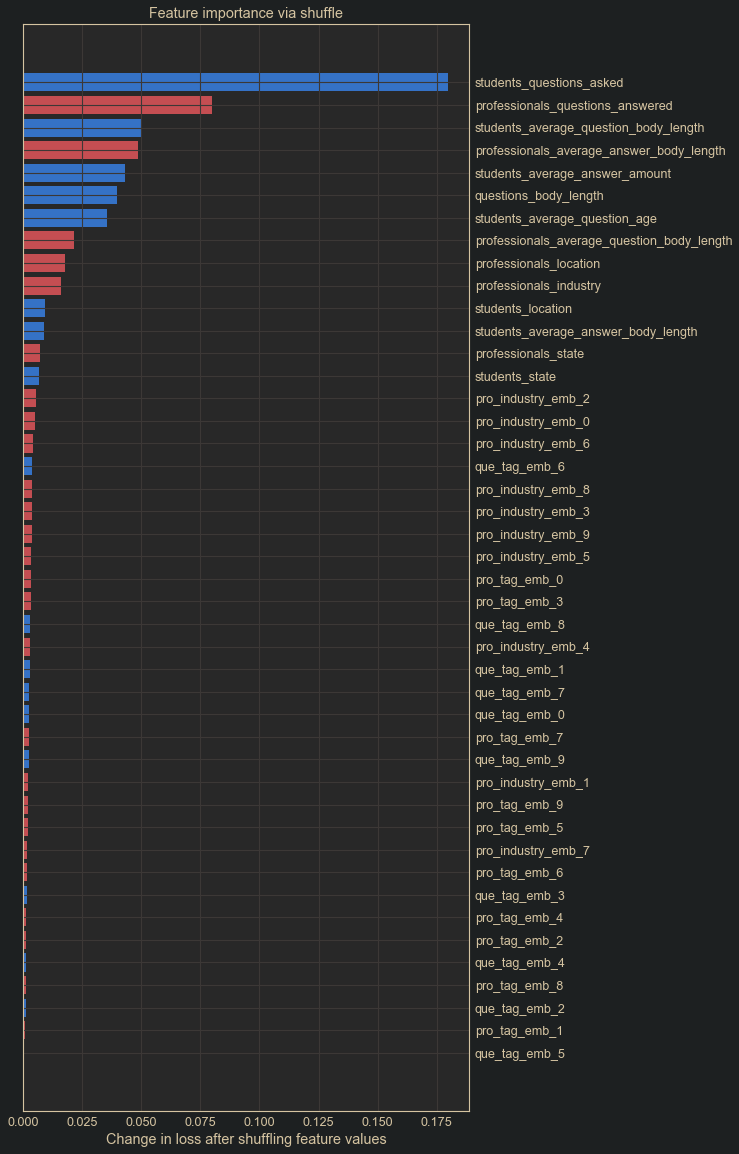

In [61]:
# calculate and plot train feature importance
fi = evaluation.permutation_importance(
    double_model.content_model, train_big_bg[0][0], train_big_bg[0][1],
    qfn, pfn, ~que_date_mask, ~pro_date_mask)
evaluation.plot_fi(fi, qfn, pfn)

Begin2
1024/1024 [==============================] - ETA:  - ETA:  - ETA:  - 0s 138us/step


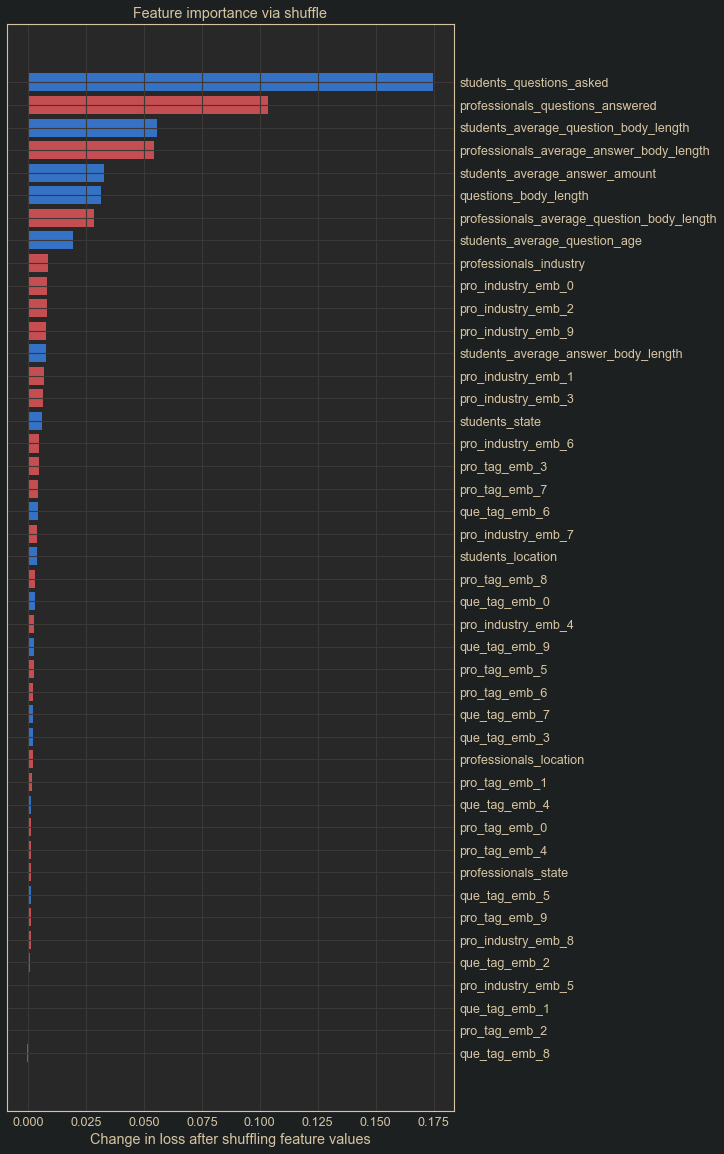

In [62]:
# calculate and plot test feature importance
fi = evaluation.permutation_importance(
    double_model.content_model, test_big_bg[0][0], test_big_bg[0][1],
    qfn, pfn, ~que_date_mask, ~pro_date_mask)
evaluation.plot_fi(fi, qfn, pfn)

### Date model feature importance

Begin2
1024/1024 [==============================] - ETA:  - ETA:  - 0s 102us/step


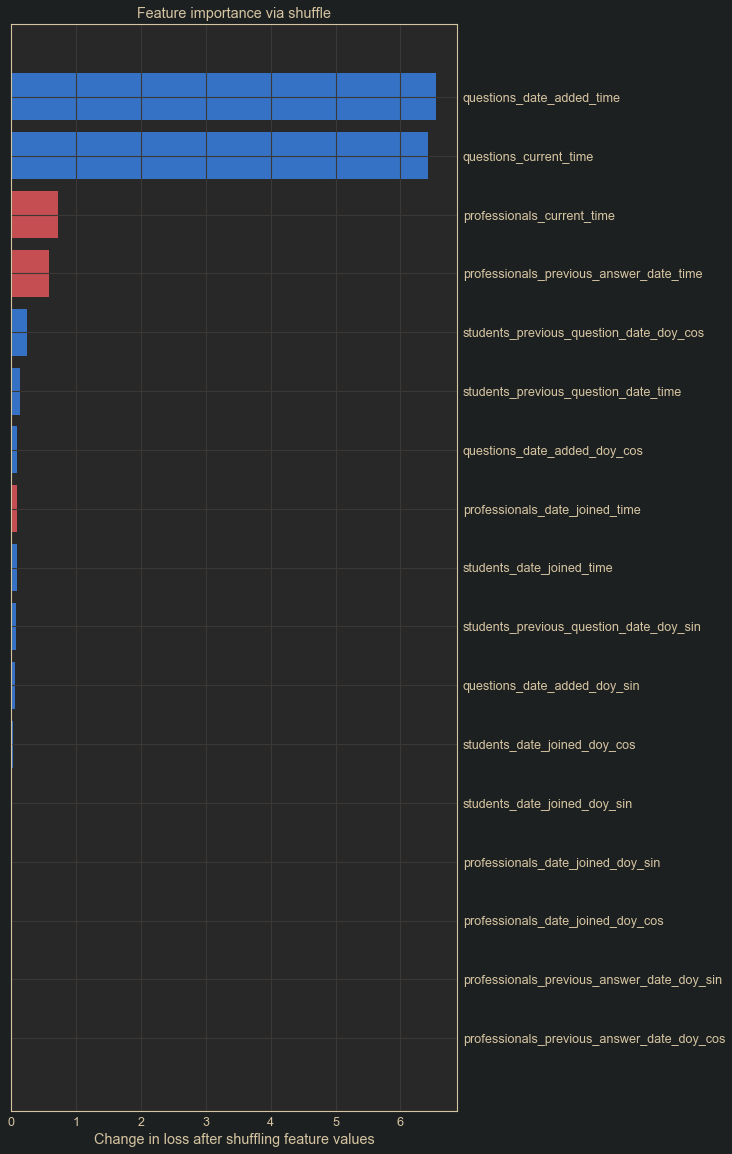

In [56]:
# calculate and plot train feature importance
fi = evaluation.permutation_importance(
    double_model.date_model, train_big_bg[0][0], train_big_bg[0][1],
    qfn, pfn, que_date_mask, pro_date_mask)
evaluation.plot_fi(fi, qfn, pfn)

Begin2
1024/1024 [==============================] - ETA:  - ETA:  - 0s 92us/step


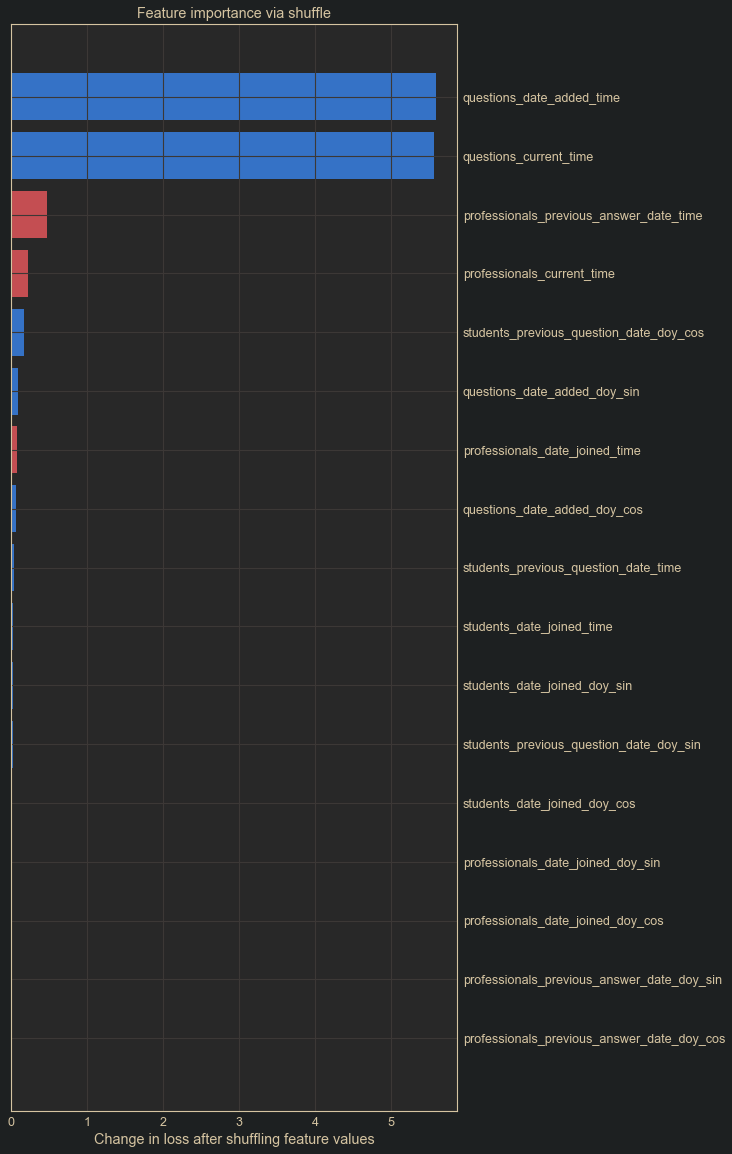

In [57]:
# calculate and plot test feature importance
fi = evaluation.permutation_importance(
    double_model.date_model, test_big_bg[0][0], test_big_bg[0][1],
    qfn, pfn, que_date_mask, pro_date_mask)
evaluation.plot_fi(fi, qfn, pfn)

---